In [1]:
import os, sys
import rasterio
import argparse
import yaml
import numpy as np
from tqdm import tqdm
from pathlib import Path
import seaborn as sns
import pandas as pd
from argparse import Namespace
import matplotlib.pyplot as plt
os.chdir("/scratch/ewalt/pdm/rs-uncertainty/")

In [2]:
def pjoin(*subs): return Path(os.path.abspath(os.path.join(*subs)))

In [3]:
# load config
args = Namespace()
args.cfg = Path("./config/evaluate_testset/baseline.yaml")
with args.cfg.open("r", encoding="utf-8") as f:
    cfg = yaml.safe_load(f)

In [11]:
cfg

{'data_bands': [1, 2, 3, 4, 5],
 'variable_names': ['P95', 'MeanH', 'Dens', 'Gini', 'Cover'],
 'projects_east': ['346',
  '9',
  '341',
  '354',
  '415',
  '418',
  '416',
  '429',
  '439',
  '560',
  '472',
  '521',
  '498',
  '522',
  '564',
  '764',
  '781',
  '825',
  '796',
  '805',
  '827',
  '891',
  '835',
  '920',
  '959',
  '1023',
  '998',
  '527',
  '477',
  '542',
  '471'],
 'projects_west': ['528', '537', '792', '988', '769'],
 'projects_north': ['819', '909', '896'],
 'pkl_dir': 'data/2023-04-05_18-58-33',
 'prediction_dir': 'results/2023-04-06_10-52-04_baseline',
 'gt_dir': 'assets/data/preprocessed',
 'num_bins': 1000}

In [4]:
projects = cfg["projects_east"]+cfg["projects_west"]+cfg["projects_north"]
# with Path("/scratch/ewalt/pdm/rs-uncertainty/assets/data/pkl/2021-05-18_10-57-45/stats.yaml").open() as f:
#     stats = yaml.safe_load(f)
# labels_mean = np.array(stats["labels_mean"]).reshape(5,1,1)
# labels_std = np.array(stats["labels_std"]).reshape(5,1,1)
with pjoin(cfg["pkl_dir"], "stats.yaml").open("r", encoding="utf-8") as f:
    stats = yaml.safe_load(f)
labels_mean = np.array(stats["labels_stats"]["mean"]).reshape(5,1,1)
labels_std = np.array(stats["labels_stats"]["std"]).reshape(5,1,1)

In [5]:
# iterate and standardize
variables = ['P95', 'MeanH', 'Dens', 'Gini', 'Cover']
def add(arr, source, state, pid):
    arr = arr.reshape(-1,)   
    data["number"].extend(arr.tolist())
    for variable in variables:
        data["variables"].extend([variable for _ in range(int(arr.shape[0]//5))])
    data["sources"].extend([source for _ in range(arr.shape[0])])
    data["states"].extend([state for _ in range(arr.shape[0])])
    data["project_id"].extend([pid for _ in range(arr.shape[0])])
MAX_PROJECTS = 2
counter = 0
data = {
    "number": [],
    "variables": [],
    "sources": [],
    "states": [],
    "project_id": [],
}
for mean_file in tqdm(Path(cfg["prediction_dir"]).glob('*_mean.tif')):
# for mean_file in Path("/scratch/ewalt/pdm/rs-uncertainty/results/2023-04-05_15-46-48").glob('*_mean.tif'):
    counter += 1
    # load data
    project = mean_file.stem.split('_')[0]
    if project not in projects: continue
    with rasterio.open(mean_file) as fh:
        mean = fh.read(fh.indexes)
    with rasterio.open(pjoin(cfg['prediction_dir'], f"{project}_variance.tif")) as fh:
    # with rasterio.open(pjoin("/scratch/ewalt/pdm/rs-uncertainty/results/2023-04-05_15-46-48", f"{project}_variance.tif")) as fh:
        variance = fh.read(fh.indexes)
    with rasterio.open(pjoin(cfg['gt_dir'], f"{project}.tif")) as fh:
        gt = fh.read(fh.indexes)
        gt_mask = fh.read_masks(1).astype(np.bool_)
    # print(gt.shape, gt_mask.shape, np.isnan(mean).shape)
    # standardize
    variance_after = variance/(labels_std)**2
    mean_after = (mean-labels_mean)/labels_std
    gt_after = (gt-labels_mean)/labels_std 
    # mask
    mean_mask = ~np.isnan(mean).all(0)
    print("mean_mask included in gt_mask?", (gt_mask[mean_mask==False]==False).all())
    print("gt_mask included in mean_mask?", (mean_mask[gt_mask==False]==False).all())
    mask = np.logical_and(~np.isnan(mean).all(0), gt_mask)
    # print(mask.shape)
    mean = mean[:,mask]
    variance = variance[:,mask]
    gt = gt[:,mask]
    mean_after = mean_after[:,mask]
    variance_after = variance_after[:,mask]
    gt_after = gt_after[:,mask]
    # add flatten
    add(mean, "before", "mean", project)
    add(mean_after, "after", "mean", project)
    add(variance, "before", "variance", project)
    add(variance_after, "after", "variance", project)
    add(gt, "before", "gt", project)
    add(gt_after, "after", "gt", project)
    if counter == MAX_PROJECTS: break
data = pd.DataFrame(data)
data.dropna(inplace=True)
data.reset_index(drop=True,inplace=True)

0it [00:00, ?it/s]

mean_mask included in gt_mask? False
gt_mask included in mean_mask? True


1it [00:00,  1.55it/s]

mean_mask included in gt_mask? False
gt_mask included in mean_mask? True


In [6]:
data

,number,variables,sources,states,project_id
0,8.502655,P95,before,mean,354
1,10.068137,P95,before,mean,354
2,9.986108,P95,before,mean,354
3,9.772894,P95,before,mean,354
4,10.092015,P95,before,mean,354
...,...,...,...,...,...
4588585,-0.787233,Cover,after,gt,415
4588586,-0.155484,Cover,after,gt,415
4588587,0.067487,Cover,after,gt,415
4588588,0.364780,Cover,after,gt,415


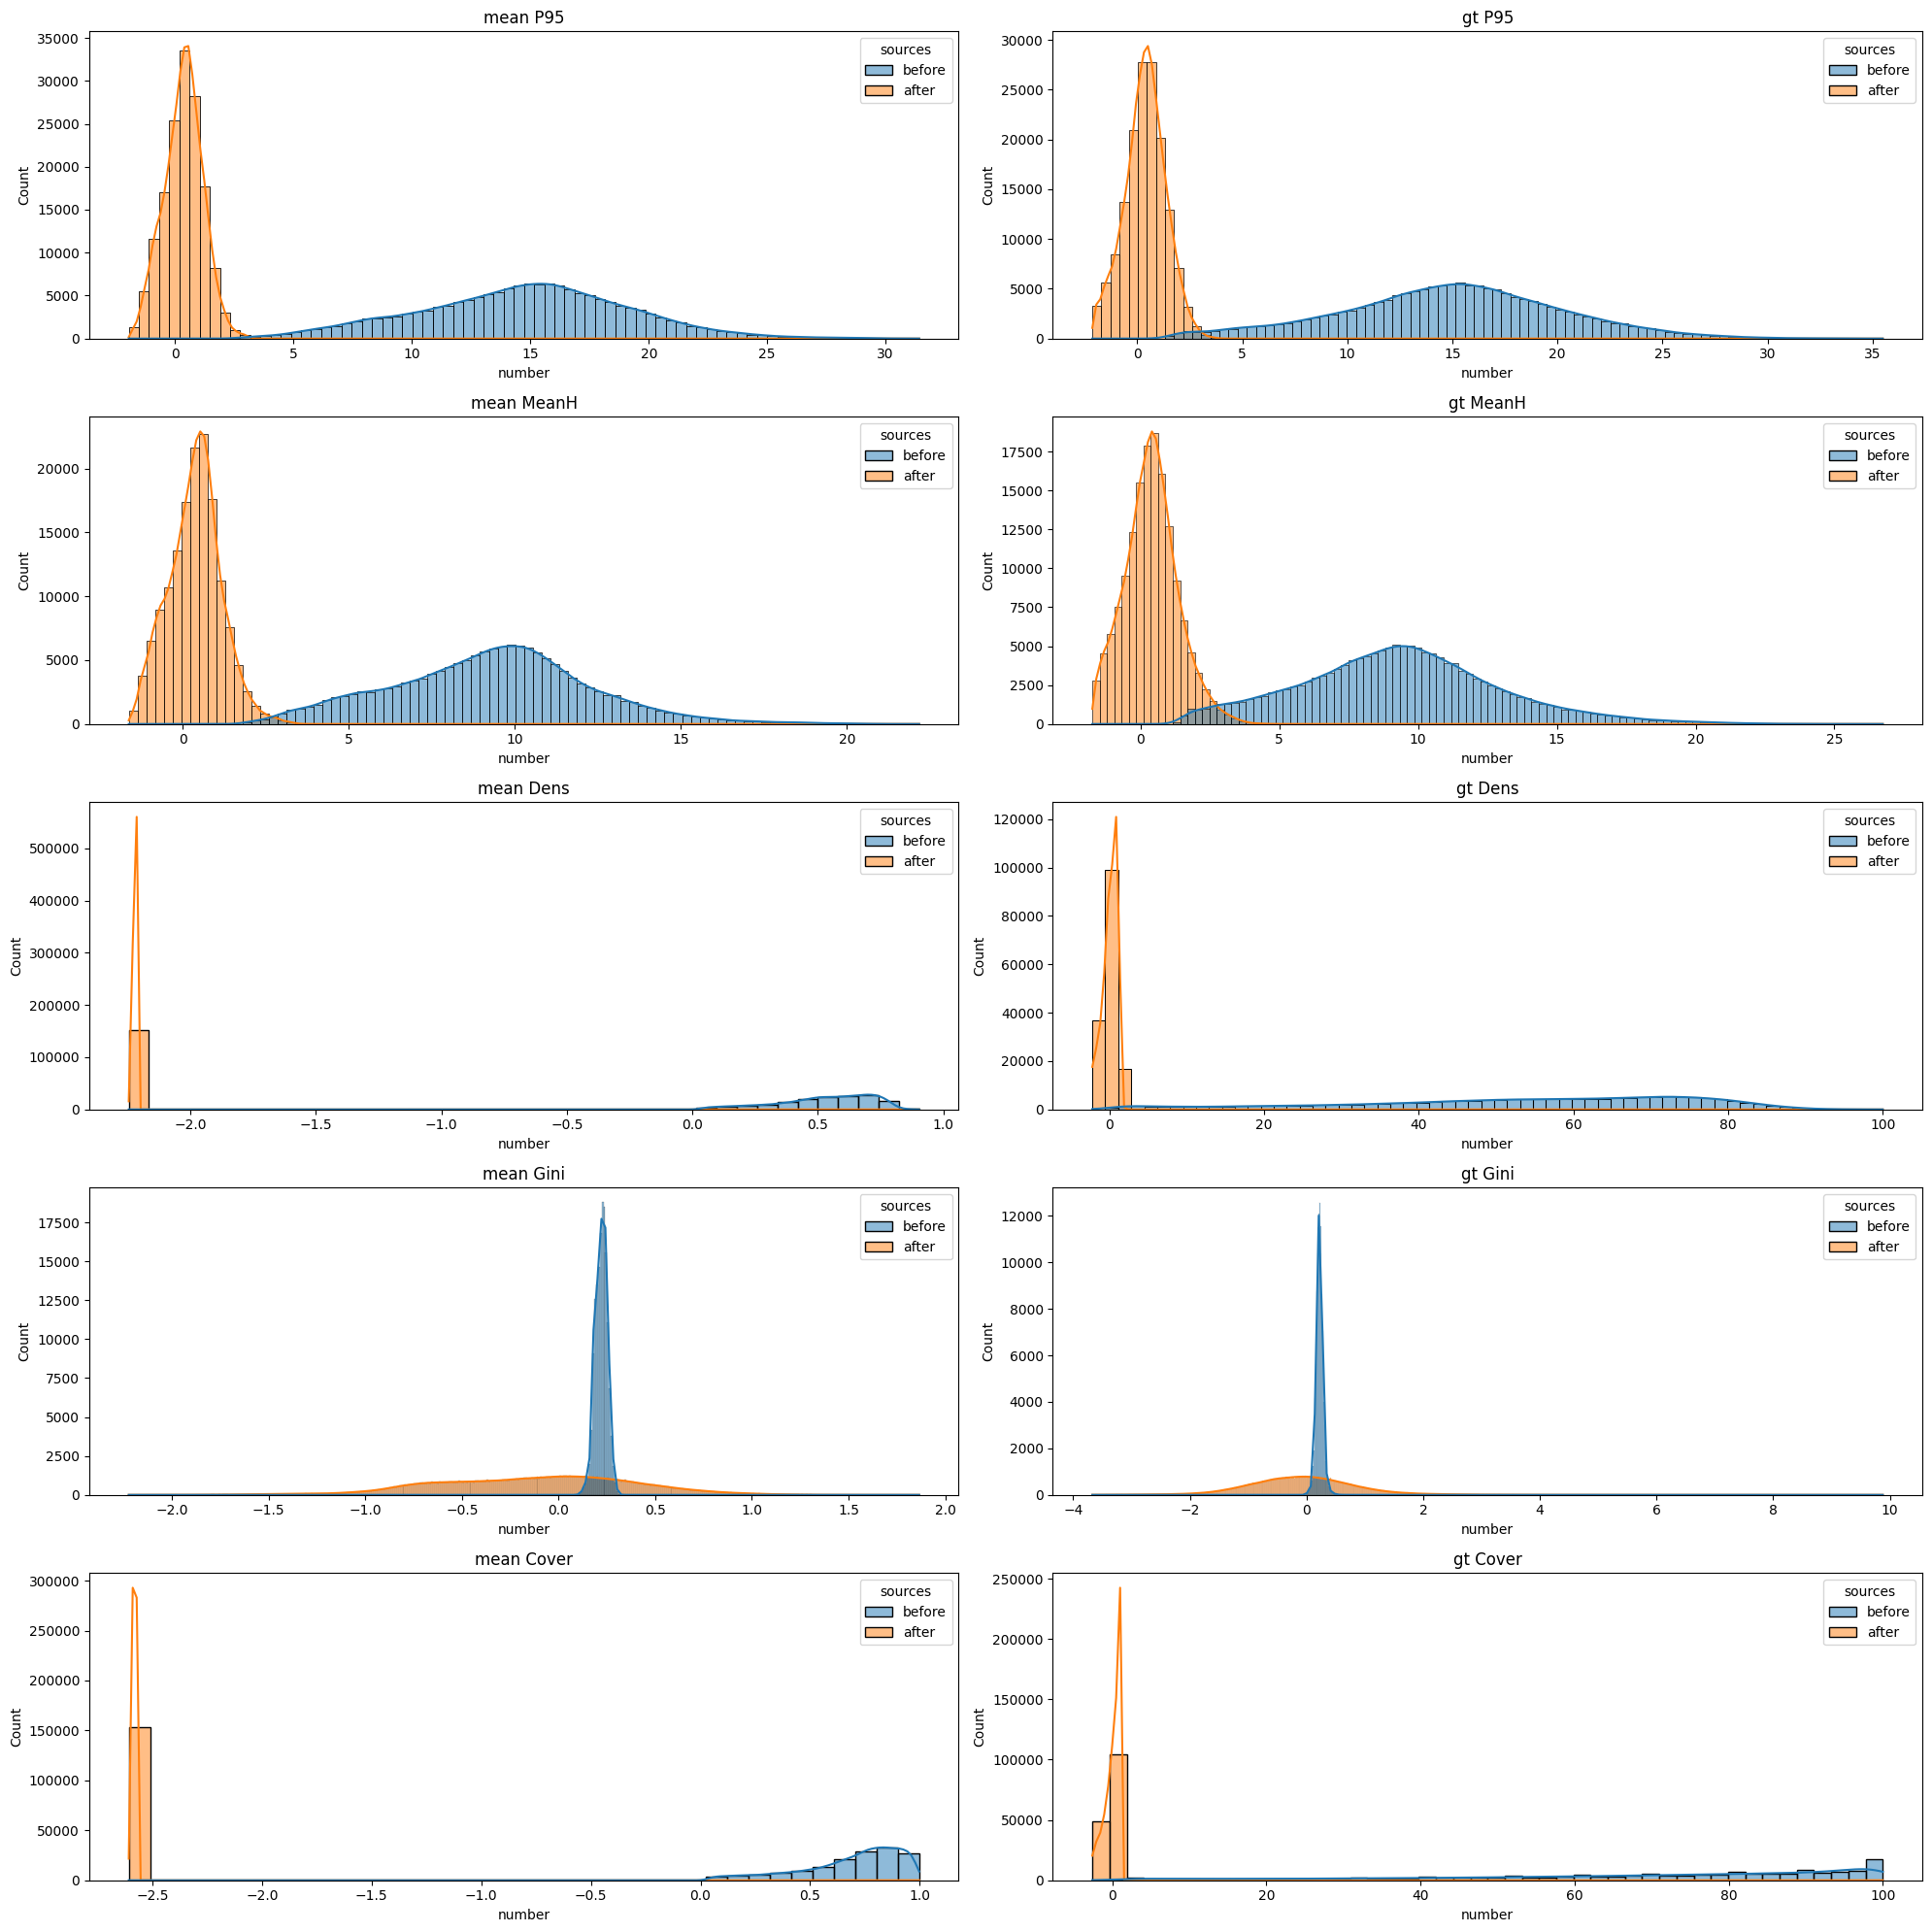

In [7]:
states = ["mean", "gt"]
fig, axs = plt.subplots(nrows=len(data.variables.unique()), ncols=len(states), figsize=(20,20))
for i, variable in enumerate(data.variables.unique()):
    for j, state in enumerate(states):
        if state=="variance": continue
        sub = data.copy()
        sub = sub[sub.variables==variable]
        sub = sub[sub.states==state]
        sns.histplot(data=sub, x="number", hue="sources", kde=True, ax=axs[i,j])
        axs[i,j].set_title(f"{state} {variable}")
plt.tight_layout()
plt.show()


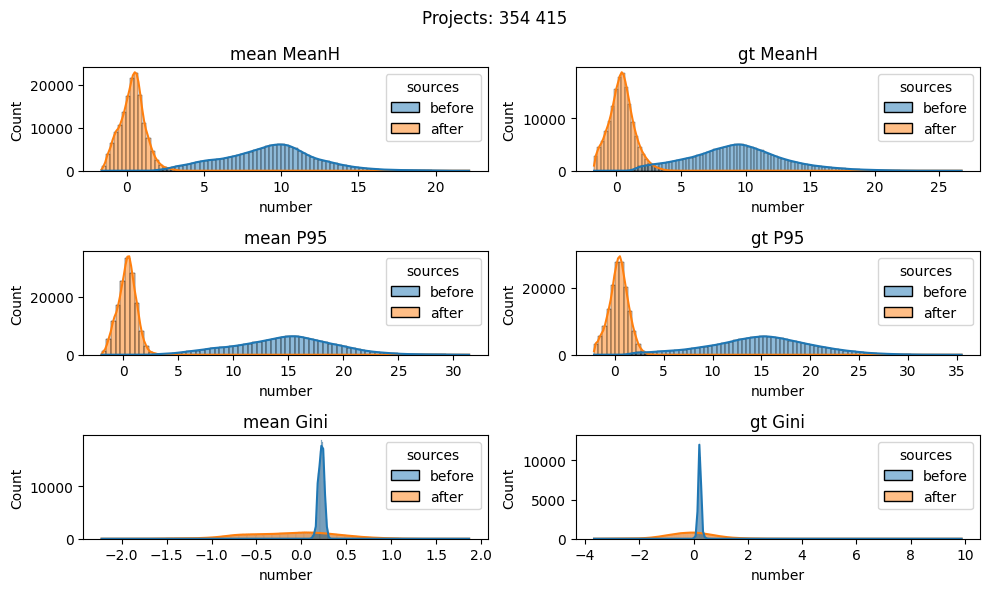

In [8]:
states = ["mean", "gt"]
variables = ["MeanH", "P95", "Gini"]
fig, axs = plt.subplots(nrows=len(variables), ncols=len(states), figsize=(10,6))
for i, variable in enumerate(variables):
    for j, state in enumerate(states):
        if state=="variance": continue
        sub = data.copy()
        sub = sub[sub.variables==variable]
        sub = sub[sub.states==state]
        sns.histplot(data=sub, x="number", hue="sources", kde=True, ax=axs[i,j])
        axs[i,j].set_title(f"{state} {variable}")
fig.suptitle("Projects: {}".format(" ".join(list(data.project_id.unique()))))
plt.tight_layout()
# plt.savefig("notebooks/standardization_ok.png")
plt.show()

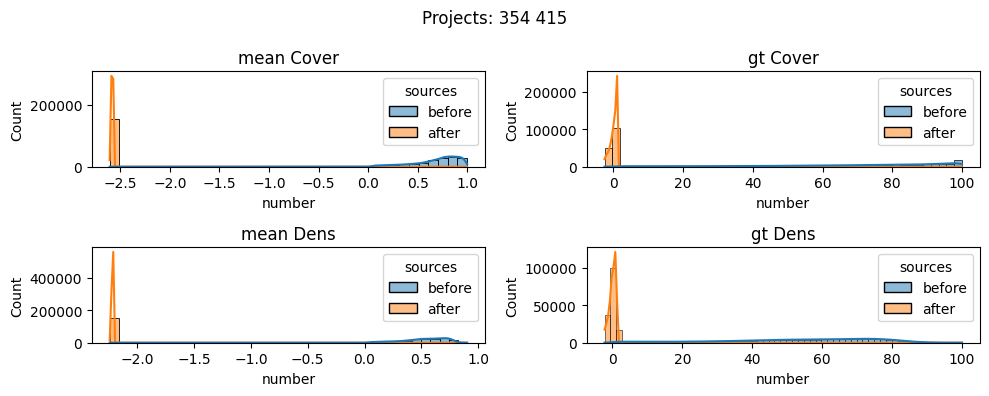

In [9]:
states = ["mean", "gt"]
variables = ["Cover", "Dens"]
fig, axs = plt.subplots(nrows=len(variables), ncols=len(states), figsize=(10,4))
for i, variable in enumerate(variables):
    for j, state in enumerate(states):
        if state=="variance": continue
        sub = data.copy()
        sub = sub[sub.variables==variable]
        sub = sub[sub.states==state]
        sns.histplot(data=sub, x="number", hue="sources", kde=True, ax=axs[i,j])
        axs[i,j].set_title(f"{state} {variable}")
fig.suptitle("Projects: {}".format(" ".join(list(data.project_id.unique()))))
plt.tight_layout()
# plt.savefig("notebooks/standardization_issues.png")
plt.show()

## Trying to understand the issue

In [19]:
# Are the predictions activated?
with open("config/predict_testset/baseline.yaml", "r") as f:
    pcfg = yaml.safe_load(f)
for i in range(len(pcfg["checkpoint_dirs"])):
    with pjoin(pcfg["checkpoint_dirs"][i], "config.yaml").open("r") as f:
        tmp = yaml.safe_load(f)
        print(
            pcfg["checkpoint_dirs"][i].split("/")[-1],
            "activate_mean:",
            tmp["training"]["activate_mean"]
        )
# yes

21-06-03_18-13-47_strict-kingfisher-123 activate_mean: True
21-06-03_18-08-21_maroon-trogon-122 activate_mean: True
21-06-03_18-02-15_sturdy-cuckoo-121 activate_mean: True
21-06-03_18-13-55_towering-muskox-124 activate_mean: True
21-06-03_18-17-26_mature-collie-125 activate_mean: True


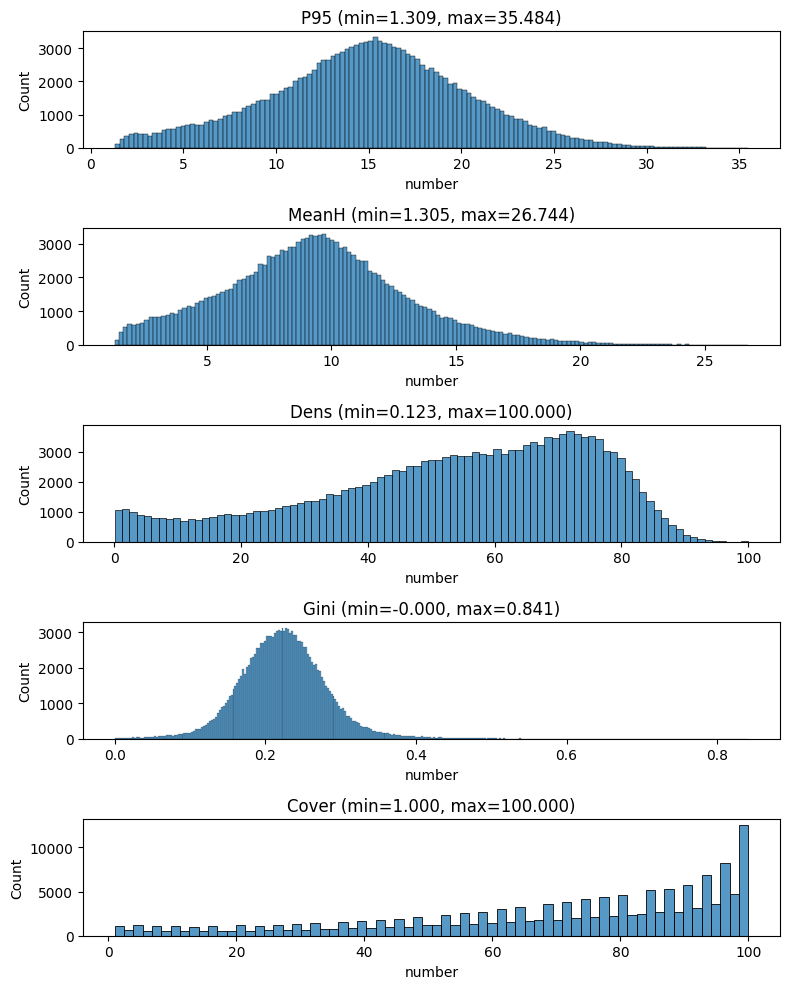

In [78]:
# Show all gt before
variables = ['P95', 'MeanH', 'Dens', 'Gini', 'Cover']
f, axs = plt.subplots(nrows=len(variables), ncols=1, figsize=(8,10))
for i, var in enumerate(variables):
    tmp = data.query(f"states == 'gt' & variables == '{var}' & sources == 'before'")
    sns.histplot(data=tmp, x="number", ax=axs[i])
    axs[i].set_title(f"{var} (min={tmp.number.min():.3f}, max={tmp.number.max():.3f})")
plt.tight_layout()
plt.savefig("notebooks/gt_distros.png")
plt.show()

In [63]:
def show_constraints_violations(df, variable, constraints):
    var = df.query(f"variables == '{variable}' & states != 'variance'")
    var_before = var[var.sources=="before"]
    var_after = var[var.sources=="after"]
    print(variable, "violation rate:")
    for constraint in constraints:
        gt_before_rate = var_before[var_before.states=="gt"].query(constraint).shape[0]/var_before[var_before.states=="gt"].shape[0]
        gt_after_rate = var_after[var_after.states=="gt"].query(constraint).shape[0]/var_after[var_after.states=="gt"].shape[0]
        mean_before_rate = var_before[var_before.states=="mean"].query(constraint).shape[0]/var_before[var_before.states=="mean"].shape[0]
        mean_after_rate = var_after[var_after.states=="mean"].query(constraint).shape[0]/var_after[var_after.states=="mean"].shape[0]
        print(f"\t{constraint}:")
        print(f"\t\tbefore -> (gt={gt_before_rate*100:.2f}%,mean={mean_before_rate*100:.2f}%)")
        print(f"\t\tafter  -> (gt={gt_after_rate*100:.2f}%,mean={mean_after_rate*100:.2f}%)")

In [67]:
# Are the constraints verified
variables = ['P95', 'MeanH', 'Dens', 'Gini', 'Cover']
for i, var in enumerate(variables):
    show_constraints_violations(
        data,
        var,
        ["number < 0"] if i<2 else ["number < 0", "number > 1"]
    )
# For prediction yes, for gt P95, MeanH, Gini yes Dens, Cover no
# which makes no sense

P95 violation rate:
	number < 0:
		before -> (gt=0.00%,mean=0.00%)
		after -> (gt=33.06%,mean=32.13%)
MeanH violation rate:
	number < 0:
		before -> (gt=0.00%,mean=0.00%)
		after -> (gt=33.54%,mean=30.59%)
Dens violation rate:
	number < 0:
		before -> (gt=0.00%,mean=0.00%)
		after -> (gt=41.93%,mean=100.00%)
	number > 1:
		before -> (gt=99.52%,mean=0.00%)
		after -> (gt=15.86%,mean=0.00%)
Gini violation rate:
	number < 0:
		before -> (gt=0.00%,mean=0.00%)
		after -> (gt=54.22%,mean=56.99%)
	number > 1:
		before -> (gt=0.00%,mean=0.00%)
		after -> (gt=10.45%,mean=0.81%)
Cover violation rate:
	number < 0:
		before -> (gt=0.00%,mean=0.00%)
		after -> (gt=41.86%,mean=100.00%)
	number > 1:
		before -> (gt=99.73%,mean=0.00%)
		after -> (gt=11.30%,mean=0.00%)


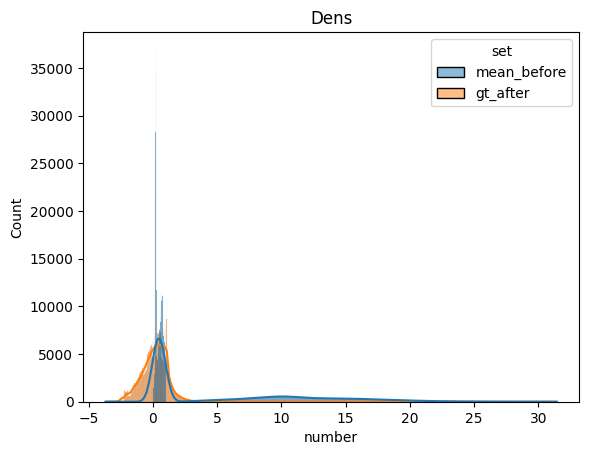

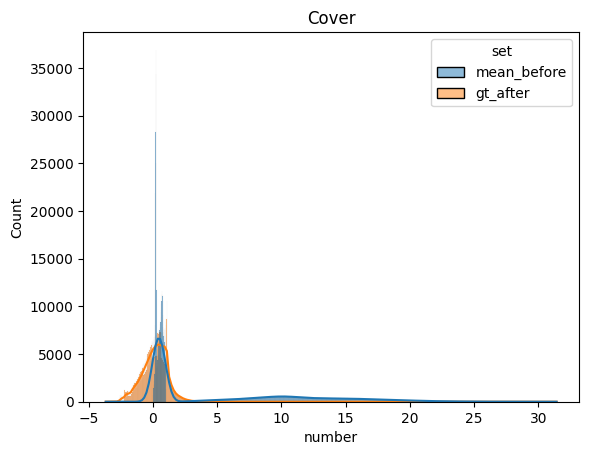

In [74]:
# Could it be that for some reason the Cover and Dens GT must be normalized ?
# Compare mean_before with gt_after
import warnings
warnings.simplefilter("ignore")
for var in ["Dens", "Cover"]:
    tmp = data[data.variables==var]
    tmp_mean_before = data.query("states == 'mean' & sources == 'before'")
    tmp_gt_after = data.query("states == 'gt' & sources == 'after'")
    tmp_mean_before["set"] = "mean_before"
    tmp_gt_after["set"] = "gt_after"
    tmp = pd.concat([tmp_mean_before, tmp_gt_after])
    sns.histplot(data=tmp, x="number", hue="set", kde=True)
    plt.title(var)
    plt.show()
# They do seem pretty close... BUT there mean_before respects (0,1) constraint
# while gt_after does not (<0)

In [70]:
tmp

,number,variables,sources,states,project_id,set
0,8.502655,P95,before,mean,354,mean_before
1,10.068137,P95,before,mean,354,mean_before
2,9.986108,P95,before,mean,354,mean_before
3,9.772894,P95,before,mean,354,mean_before
4,10.092015,P95,before,mean,354,mean_before
...,...,...,...,...,...,...
4588585,-0.787233,Cover,after,gt,415,gt_after
4588586,-0.155484,Cover,after,gt,415,gt_after
4588587,0.067487,Cover,after,gt,415,gt_after
4588588,0.364780,Cover,after,gt,415,gt_after


In [254]:
1664*480

798720

In [253]:
gt.shape, gt_mask.shape

((5, 23118), (1664, 480))

In [251]:
gt[:,gt_mask]

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [245]:
np.isnan(mean).all(0).shape

(23118,)

In [235]:
np.isnan(mean).all(axis=0, keepdims=True).shape

(1, 23118)

In [121]:
data.query("states == 'gt' & variables == 'P95'").number.unique()

array([-9.99999000e+05,  7.33900023e+00,  1.21914997e+01, ...,
       -2.34945420e+00, -2.22382446e+00, -1.95827121e+00])

In [153]:
(gt==-9.99999000e+05).sum()/gt.reshape(-1,).shape[0]

0.35037935697115385

In [155]:
(gt<0).sum()/gt.reshape(-1,).shape[0]

0.35038561698717946

In [163]:
with rasterio.open(pjoin(cfg['gt_dir'], f"{project}.tif")) as fh:
    gt = fh.read(fh.indexes)
    gt_mask = fh.read_masks(1).astype(np.bool_)

In [169]:
([gt==-9.99999000e+05]==gt_mask).sum()/gt_mask.reshape(-1,).shape[0]

0.4139247796474359

In [170]:
gt.shape, gt_mask.shape

((5, 1664, 480), (1664, 480))

In [177]:
np.count_nonzero(((gt[0]==-9.99999000e+05)==gt_mask))/(gt_mask.shape[0]*gt_mask.shape[1])

0.07052033253205128

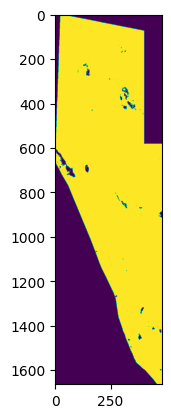

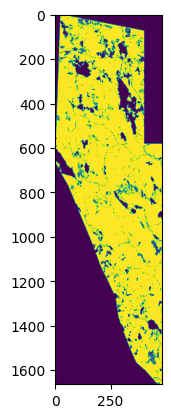

In [185]:
probably_ok = (gt[0]!=-9.99999000e+05)
definitely_ok = gt_mask
plt.imshow(probably_ok)
plt.show()
plt.imshow(definitely_ok)
plt.show()

In [183]:
np.logical_and(probably_ok

False

In [184]:
definitely_ok[0,0]

False

In [188]:
(np.isnan(mean)==([gt==-9.99999000e+05]))

array([[[[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True,  True,  True, ..., False, False, False],
         [ True,  True,  True, ..., False, False, False],
         [ True,  True,  True, ..., False, False, False]],

        [[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True,  True,  True, ..., False, False, False],
         [ True,  True,  True, ..., False, False, False],
         [ True,  True,  True, ..., False, False, False]],

        [[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True,  True,  True, ..., False, False, False],
         [ True,  True,  T